# ECE 657A ASSIGNMENT 3
## Climate Fever Dataset

###### Jubilee Imhanzenobe and Olohireme Ajayi

In [1]:
# importing the libraries
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec, KeyedVectors
from datasets import load_dataset
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import warnings
from pandas.core.common import SettingWithCopyWarning

In [2]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
# downloading nltk.punkt
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

### Defining relevant functions

In [4]:
def word_cloud_plot (data):
    """
    function that creates a word cloud from a specified column of a dataframe 
    """
    # create set of stopwords
    stopwords = set(STOPWORDS)

    # Instantiate the word cloud object
    word_cloud = WordCloud(background_color='white',max_words=200,stopwords=stopwords, width=800, height=400)
    
    # generate the word cloud
    word_cloud.generate(' '.join(data))
    
    # To display the word cloud
    plt.figure( figsize=(20,10) )
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [5]:
def regex_filter(sentence):
    """
    funtion that formats string to remove special characters
    """
    import re
    return re.sub('[^a-zA-Z]', ' ', sentence)

In [6]:
def filter_stop_words(token):
    """
    function that removes stopwords from a word-tokenized sentence
    """
    stop_words = set(stopwords.words('english'))
    filtered_token = [word.lower() for word in token if word.lower() not in stop_words]
    return filtered_token

In [7]:
def stem_words(token):
    """
    function that stems word-tokenized sentences
    """
    ps = PorterStemmer()
    stemmed_token = [ps.stem(word) for word in token]
    return stemmed_token

In [8]:
def lemmatize_words(token):
    """
    function that lemmatizes word-tokenized sentences
    """
    lem = WordNetLemmatizer()
    lemmatized_token = [lem.lemmatize(word, 'v') for word in token]
    return lemmatized_token

In [9]:
def join_token(token):
    """
    function that joins word-tokenized sentences back to single string
    """
    return ' '.join(token)

In [10]:
def get_embeddings(group, model):
    """
    Function for getting embeddings of words from a word2vec model 
    """
    group_embedding = []
    group_labels = []
    
    unique_words = [word for sentence in group for word in sentence]
    unique_words = list(dict.fromkeys(unique_words))
    
    for word in unique_words:
        if model.wv.__contains__(word):
            group_embedding.append(list(model.wv.__getitem__(word)))
            group_labels.append(word)
            
    df_embedding = pd.DataFrame(group_embedding)
    df_word = pd.DataFrame(group_labels, columns = ["Word"])
    df = pd.concat([df_word, df_embedding], axis=1)
    return df

In [11]:
def similarity(words, stem_model=None, lem_model=None, W2V_pretrained=None, GloVe_pretrained=None):
    """
    function that computes similarity between words for up to four models passed 
    """
    if stem_model:
        ps = PorterStemmer()
        stemmed = [ps.stem(word) for word in words]
        try:
            print("Stemmed W2V model similarity between", words[0], "and", words[1], "=", stem_model.wv.similarity(stemmed[0], stemmed[1]))
        except:
            print("Error: Word not in stem model vocabulary")
    
    if lem_model:
        lem = WordNetLemmatizer()
        lemma = [lem.lemmatize(word, 'v') for word in words]
        try:
            print("Lemmatized W2V model similarity between", words[0], "and", words[1], "=", lem_model.wv.similarity(lemma[0], lemma[1]))
        except:
            print("Error: Word not in lemmatized model vocabulary")        
    
    if W2V_pretrained:
        try:
            print("Word2vec pretrained model similarity between", words[0], "and", words[1], "=", W2V_pretrained.wv.similarity(words[0], words[1]))
        except:
            print("Error: Word not in Word2vec pretrained model vocabulary")
    
    if GloVe_pretrained:
        try:
            print("GloVe pretrained model similarity between", words[0], "and", words[1], "=", GloVe_pretrained.similarity(words[0], words[1]))
        except:
            print("Error: Word not in GloVe pretrained model vocabulary")    

In [12]:
def tsne_plot(df):
    """
    function that plots annotated scatter plot from a dataframe
    """
    plt.figure(figsize=(18, 18)) 
    for i in range(len(df)):
        plt.scatter(df.iloc[i,1],df.iloc[i,2])
        plt.annotate(df.iloc[i,0],
                     xy=(df.iloc[i,1], df.iloc[i,2]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [13]:
def get_sentence_embedding(data, column, train_word_embedding, test_word_embedding):
    """
    function that creates a sentence embedding from the embeddings of the individual words
    sentence_embedding = average of word embeddings for all words in the sentence
    """
    data.reset_index(inplace=True, drop = True)
    sentence_embeddings = []
    for token in data[column]:
        embeddings = []
        for word in token:
            if word in train_word_embedding.index:
                embeddings.append(train_word_embedding.loc[word])
            else:
                embeddings.append(test_word_embedding.loc[word])
        
        embedding_array = np.array(embeddings)
        sentence_embedding = np.mean(embedding_array, axis=0)
        sentence_embeddings.append(list(sentence_embedding))
        
    features = len(sentence_embeddings[0])
    df = pd.DataFrame(sentence_embeddings, columns = ["feature_"+ str(i+1) for i in range(features)])
    df = pd.concat([data["claim"], df, data["claim_label"]], axis=1)
    return df   

In [14]:
def get_most_similar_words(embedding, n_similar = 1):
    """
    function that returns n_similar most similar words to a particular word in an embedding. 
    embedding is n x n square matrix of relationship (similarity) between words
    """
    n_similar += 1
    similar = pd.DataFrame(columns = ['most_similar_'+ str(i) for i in range(1, n_similar)])
    
    embedding_T = embedding.T
    for word in embedding.index:
        most_similar = list(embedding_T.nlargest(n = n_similar, columns = word).index)
        if word in most_similar:
            most_similar.remove(word)
        else:
            most_similar = most_similar[:-1]
            
        similar.loc[word] = most_similar
    
    return similar

In [15]:
def precision_recall_fscore(y_true, y_pred):
    """
    function that computes the precision, recall and fscore between 2 dataframes across n_columns columns
    returns the average precision, recall and fscore across the n_columns
    """
    if len(y_true) != len(y_pred):
        print("Error in dimensions of inputs")
        return
    
    n_columns = len(y_true)
    metrics = []
    
    for i in range(n_columns):
        metric = list(precision_recall_fscore_support(y_true.iloc[:,i], y_pred.iloc[:,i], average='macro'))
        metrics.append(metric[:-1])
       
    metrics = np.mean(np.array(metrics), axis=0)
        
    print("Precision: ", round(metrics[0], 2))
    print("Recall: ", round(metrics[1], 2))
    print("F1_score: ", round(metrics[2], 2))
    

In [16]:
def run_knn_opt(X_train, X_val, X_test, y_train, y_val, y_test, k_values):
    """
    function that performs tunning of k_parameter in KNN classifier
    produces confusion matrix, accuracy, fscore and screeplots
    """
    # Developing the Classification Model
    classifier = KNeighborsClassifier()
    classifier.fit(X_train,y_train)

    # Predicting the test set result
    y_pred = classifier.predict(X_test)

    # Evaluating the Model
    cm = confusion_matrix(y_test,y_pred)

    accuracy_1 = round(100 * accuracy_score(y_test,y_pred), 2)
    f1_score_1 = round(f1_score(y_test, y_pred, average = "weighted"), 2)

    y_pred_train  = classifier.predict(X_train)
    
    # Making the Confusion Matrix
    cm_train = pd.DataFrame(confusion_matrix(y_train,y_pred_train))
    cm_test = pd.DataFrame(confusion_matrix(y_test,y_pred))

    print("***** Training Set Evaluation *****\n")
    print("confusion Matrix")
    display(cm_train)
    print("Accuracy: ", round(100 * accuracy_score(y_train, y_pred_train), 2))
    print("F1_score: ", round(f1_score(y_train, y_pred_train, average = 'weighted'), 2))
    
    print("\n\n***** Test Set Evaluation *****\n")
    print("confusion Matrix")
    display(cm_test)
    print("Accuracy: ", accuracy_1)
    print("F1_score: ", f1_score_1)
    
    accuracy = {}
    for k in k_values:
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(X_train,y_train)

        # Predicting the test set result
        y_pred = classifier.predict(X_val)

        model_accuracy = accuracy_score(y_val, y_pred)

        accuracy[k] = round(model_accuracy * 100, 2)
        
    # plotting the parameter vs accuracy graph
    sns.lineplot(x = k_values, y = accuracy.values())

### Downloading the dataset

In [17]:
dataset = load_dataset('climate_fever')

df = dataset['test'].to_pandas()
df2 = pd.json_normalize(dataset['test'], 'evidences', ['claim', 'claim_id','claim_label'], errors='ignore',record_prefix='')

data1 = df[['claim', 'claim_label']]
data2 = df2[['evidence','evidence_label']]

Using custom data configuration default
Reusing dataset climate_fever (C:\Users\jubil\.cache\huggingface\datasets\climate_fever\default\1.0.1\3b846b20d7a37bc0019b0f0dcbde5bf2d0f94f6874f7e4c398c579f332c4262c)


In [18]:
data1.head()

,claim,claim_label
0,Global warming is driving polar bears toward e...,0
1,The sun has gone into ‘lockdown’ which could c...,0
2,The polar bear population has been growing.,1
3,Ironic' study finds more CO2 has slightly cool...,1
4,Human additions of CO2 are in the margin of er...,1


In [19]:
data2.head()

,evidence,evidence_label
0,"""Recent Research Shows Human Activity Driving ...",2
1,Environmental impacts include the extinction o...,0
2,Rising temperatures push bees to their physiol...,2
3,"Rising global temperatures, caused by the gree...",0
4,"""Bear hunting caught in global warming debate"".",2


### Histogram plot of claim labels and evidence labels

<AxesSubplot:xlabel='evidence_label', ylabel='Count'>

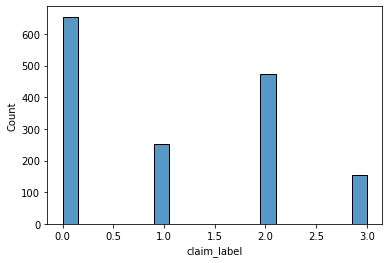

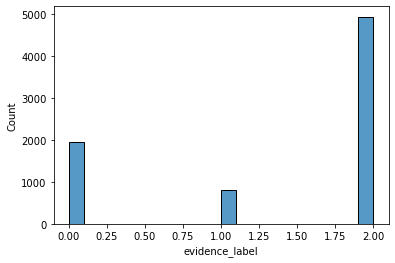

In [20]:
plt.figure()
sns.histplot(data = data1, x ='claim_label', bins = 20)
plt.figure()
sns.histplot(data = data2, x ='evidence_label', bins = 20)

### <span style="color:blue"> Comments about histogram </span>
Claim label is a feature that represents the  overall label assigned to claim (based on evidence majority vote). The label corresponds to 0: "refutes", 1: "supports" and 2: "not enough info". Class 0 has the highest number of claims

Some claims fall under a label of 3, those claims are outliers.

Evidence label also corresponds to 0: "refutes", 1: "supports" and 2: "not enough info". Most of the evidences fall under class 2.

### Word cloud of the claims in the dataset

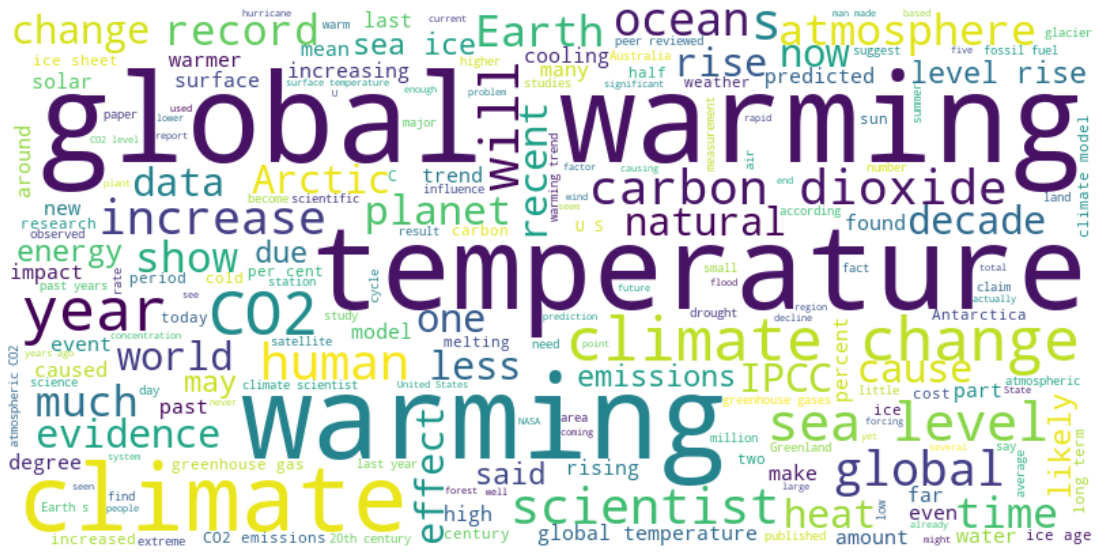

In [21]:
# visualizing word frequency in all claims
word_cloud_plot(data1['claim'])

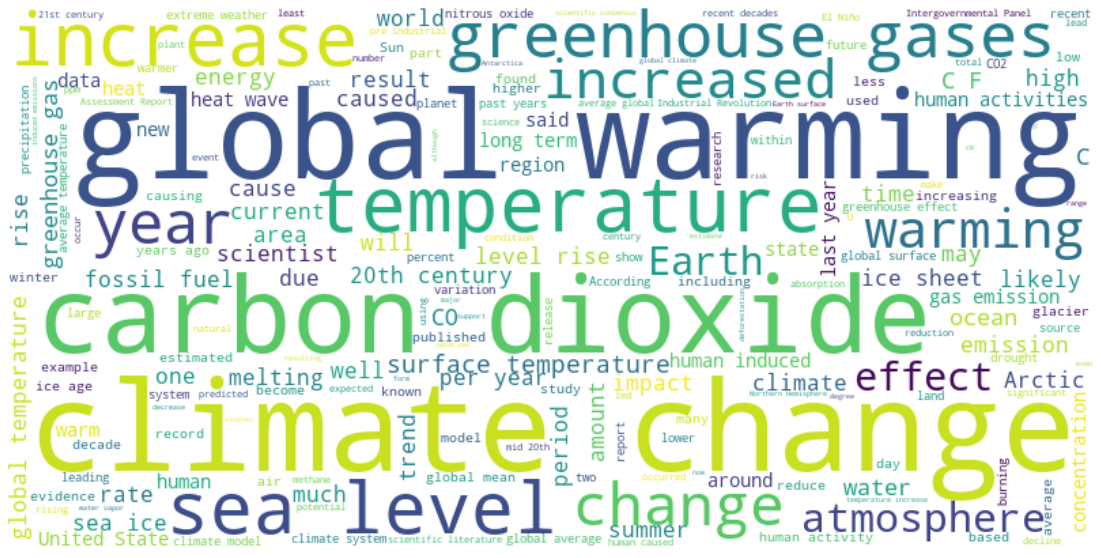

In [22]:
# visualizing word frequency in all evidences
word_cloud_plot(data2['evidence'])

### <span style="color:blue"> Notes About Word cloud </span>
In a wordcloud, the size of the word is proportional to the frequency of the word in the document. So a frequently appearing word in the document will be relatively larger in the wordcloud. It can also give an overall sense of what the document is about.

- In the claims corpus, the largest words in the cloud are 'global warming', temperature, warming, CO2, climate, change, human, carbon, dioxide, year.
- In the evidence corpus, 'global warming', temperature, warming, climate, change, human, carbon, dioxide, sea, level, greenhouse, gases.
- Basically both claims and evidence have similar most occurring words and both documents are related to climate change and global warming.

# Data preparation

### Claim Data

In [23]:
# filter with regex
data1.loc[:, 'claim_token'] = data1.loc[:, 'claim'].apply(regex_filter)

# Tokenizing the claims
data1.loc[:, 'claim_token'] = data1.loc[:, 'claim_token'].apply(nltk.word_tokenize)

# Removing stop words from the claclaim_tokenim tokens
data1.loc[:,'claim_token'] = data1.loc[:,'claim_token'].apply(filter_stop_words)

# Stemming the words
data1.loc[:,'stemmed_words'] = data1.loc[:,'claim_token'].apply(stem_words)

# lemmatizing the words
data1.loc[:,'lemmatized_words'] = data1.loc[:,'claim_token'].apply(lemmatize_words)

In [24]:
data1.head()

,claim,claim_label,claim_token,stemmed_words,lemmatized_words
0,Global warming is driving polar bears toward e...,0,"[global, warming, driving, polar, bears, towar...","[global, warm, drive, polar, bear, toward, ext...","[global, warm, drive, polar, bear, toward, ext..."
1,The sun has gone into ‘lockdown’ which could c...,0,"[sun, gone, lockdown, could, cause, freezing, ...","[sun, gone, lockdown, could, caus, freez, weat...","[sun, go, lockdown, could, cause, freeze, weat..."
2,The polar bear population has been growing.,1,"[polar, bear, population, growing]","[polar, bear, popul, grow]","[polar, bear, population, grow]"
3,Ironic' study finds more CO2 has slightly cool...,1,"[ironic, study, finds, co, slightly, cooled, p...","[iron, studi, find, co, slightli, cool, planet]","[ironic, study, find, co, slightly, cool, planet]"
4,Human additions of CO2 are in the margin of er...,1,"[human, additions, co, margin, error, current,...","[human, addit, co, margin, error, current, mea...","[human, additions, co, margin, error, current,..."


### Evidence Data

In [25]:
# Adding the evidences to increase corpus size

# filer with regex
data2.loc[:, ('evidence_token')] = data2.loc[:, ('evidence')].apply(regex_filter)

# Tokenizing the claims
data2.loc[:, ('evidence_token')] = data2.loc[:, ('evidence_token')].apply(nltk.word_tokenize)

# Removing stop words from the evidence_token tokens
data2.loc[:,('evidence_token')] = data2.loc[:,('evidence_token')].apply(filter_stop_words)

# Stemming the words
data2.loc[:,('stemmed_words')] = data2.loc[:,('evidence_token')].apply(stem_words)

# lemmatizing the words
data2.loc[:,('lemmatized_words')] = data2.loc[:,('evidence_token')].apply(lemmatize_words)

In [26]:
data2.head()

,evidence,evidence_label,evidence_token,stemmed_words,lemmatized_words
0,"""Recent Research Shows Human Activity Driving ...",2,"[recent, research, shows, human, activity, dri...","[recent, research, show, human, activ, drive, ...","[recent, research, show, human, activity, driv..."
1,Environmental impacts include the extinction o...,0,"[environmental, impacts, include, extinction, ...","[environment, impact, includ, extinct, reloc, ...","[environmental, impact, include, extinction, r..."
2,Rising temperatures push bees to their physiol...,2,"[rising, temperatures, push, bees, physiologic...","[rise, temperatur, push, bee, physiolog, limit...","[rise, temperatures, push, be, physiological, ..."
3,"Rising global temperatures, caused by the gree...",0,"[rising, global, temperatures, caused, greenho...","[rise, global, temperatur, caus, greenhous, ef...","[rise, global, temperatures, cause, greenhouse..."
4,"""Bear hunting caught in global warming debate"".",2,"[bear, hunting, caught, global, warming, debate]","[bear, hunt, caught, global, warm, debat]","[bear, hunt, catch, global, warm, debate]"


## Word cloud of the Stemmed claims in the dataset (after data preparation)

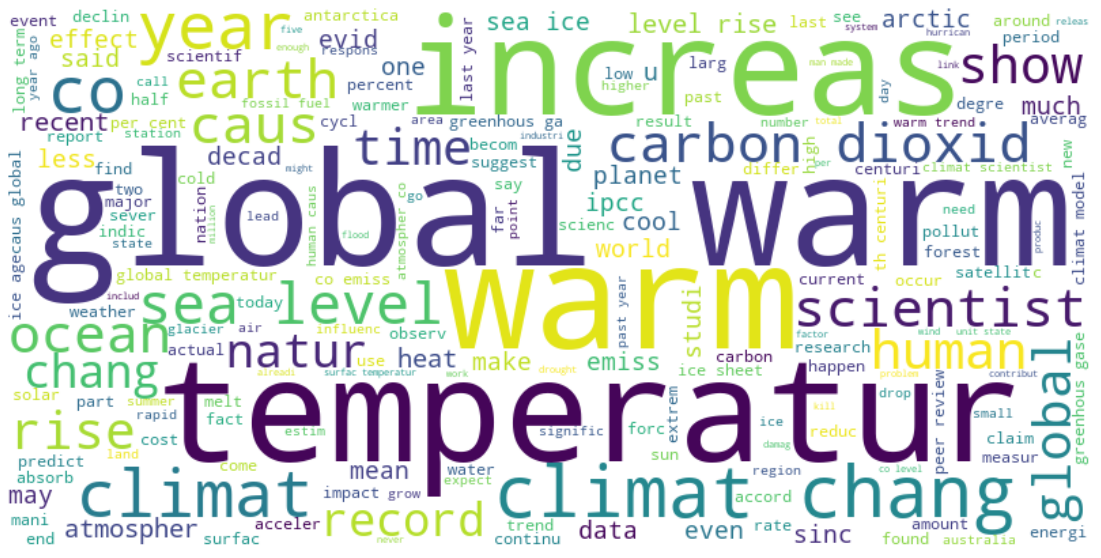

In [27]:
# Visualizing the word cloud again
word_cloud_plot(data1['stemmed_words'].apply(join_token))

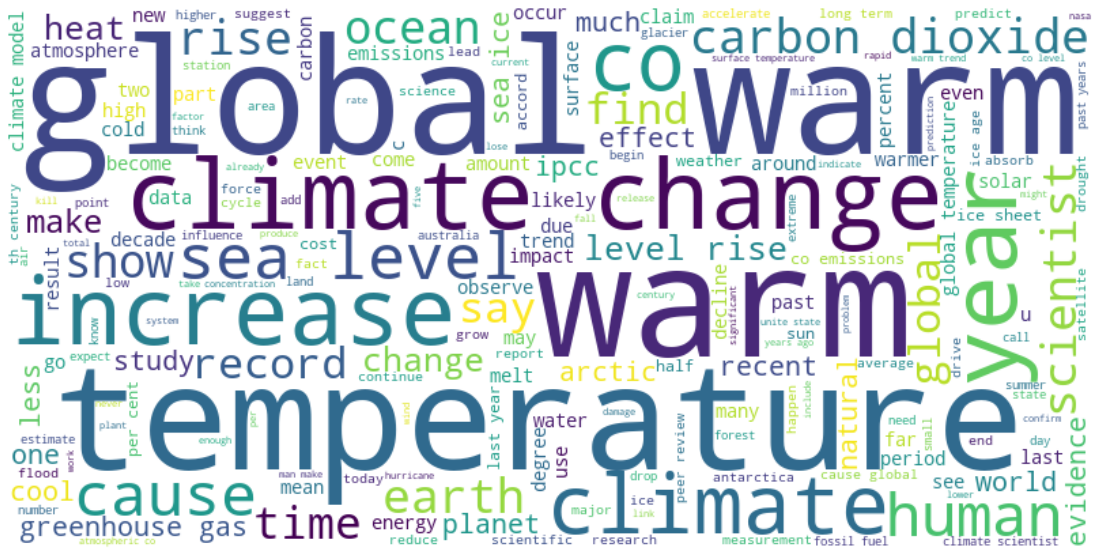

In [28]:
word_cloud_plot(data1['lemmatized_words'].apply(join_token))

### Word cloud of the Stemmed evidences in the dataset (after data preparation)

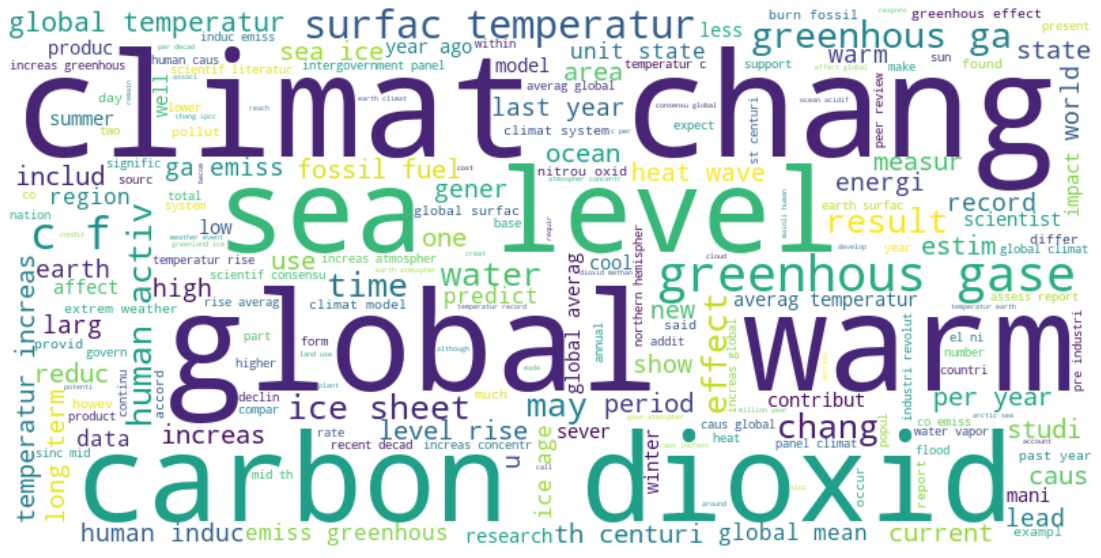

In [29]:
# Visualizing the word cloud of the evidences
word_cloud_plot(data2['stemmed_words'].apply(join_token))

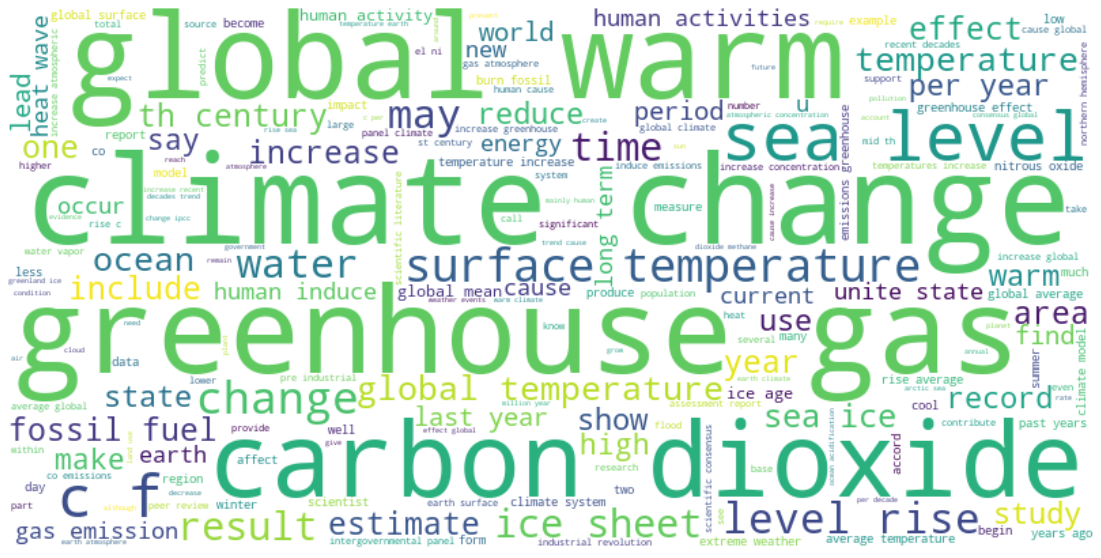

In [30]:
word_cloud_plot(data2['lemmatized_words'].apply(join_token))

### <span style="color:blue"> Notes About Word cloud after Data Processing </span>

Stemming is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language.
Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma. A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.

Reference 
https://www.datacamp.com/community/tutorials/stemming-lemmatization-python


From the word clouds of the stemmed and lemmatized words in both corpi, the most frequently occurring words are still the same but have been reduced to their respective root form based on the different methods.

## <span style="color:blue"> Q.1 Splitting the claims data into training set and test set </span>

In [31]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data1[['claim', 'stemmed_words', 'lemmatized_words', 'claim_label']], test_size=0.2, random_state=0)

In [32]:
train_data.shape

(1228, 4)

In [33]:
test_data.shape

(307, 4)

In [34]:
train_data.head()

,claim,stemmed_words,lemmatized_words,claim_label
1247,"When the PDO last switched to a cool phase, gl...","[pdo, last, switch, cool, phase, global, tempe...","[pdo, last, switch, cool, phase, global, tempe...",2
184,as time progresses and fossil fuel emissions i...,"[time, progress, fossil, fuel, emiss, increas,...","[time, progress, fossil, fuel, emissions, incr...",2
1026,Hurricanes aren't linked to global warming,"[hurrican, link, global, warm]","[hurricanes, link, global, warm]",2
1522,Ljungqvist's millennial temperature reconstruc...,"[ljungqvist, millenni, temperatur, reconstruct...","[ljungqvist, millennial, temperature, reconstr...",2
1391,"More importantly, the OISM list only contains ...","[importantli, oism, list, contain, scientist, ...","[importantly, oism, list, contain, scientists,...",2


### <span style="color:blue"> Building the Word2Vec models using entire dataset </span>

Word2vec is a technique in NLP. The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text. Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence. As the name implies, word2vec represents each distinct word with a vector. The vectors are chosen carefully such that a simple mathematical function (the cosine similarity between the vectors) indicates the level of semantic similarity between the words represented by those vectors. Unlike TF and TF-IDF, word2vec does not only encode words by their frequency alone; it combines the context of the word and its frequency in the encoding.

Reference https://en.wikipedia.org/wiki/Word2vec

In [35]:
# creating the stemmed corpus and lemmatized corpus
corpus_stem = list(data1['stemmed_words']) + list(data2['stemmed_words'])
corpus_lem = list(data1['lemmatized_words']) + list(data2['stemmed_words'])

In [36]:
# getting the length of unique stemmed words
unique_set = [word for token in corpus_stem for word in token]
unique_set = set(unique_set)
len(unique_set)

7433

In [37]:
# getting the length of unique lemmatized words
unique_set2 = [word for token in corpus_lem for word in token]
unique_set2 = set(unique_set2)
len(unique_set2)

8894

In [38]:
# Embeding with Word2Vec
model_stem = Word2Vec(corpus_stem, min_count=1)
model_lem = Word2Vec(corpus_lem, min_count=1)
print(model_stem)
print(model_lem)

Word2Vec(vocab=7433, size=100, alpha=0.025)
Word2Vec(vocab=8894, size=100, alpha=0.025)


In [39]:
len(model_stem.wv.vocab)

7433

In [40]:
len(model_lem.wv.vocab)

8894

**The Stemmed word2vec model has 7433 words in its vocabulary <br>
The Lemmatized word2vec model has 8894 words in its vocabulary**

### <span style="color:blue"> Get Word Embeddings</span>

### <span style="color:blue">Getting the training set Embeddings</span>

In [41]:
# Training set embedings [STEMMING]
train_embedding_stem = get_embeddings(list(train_data['stemmed_words']), model_stem)
train_embedding_stem.set_index("Word", inplace=True)
train_embedding_stem.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Word,,,,,,,,,,,,,,,,,,,,,
pdo,-0.000366,0.066672,0.049868,-0.302237,-0.086955,-0.045868,-0.028833,0.052663,-0.202770,-0.160051,...,0.171690,0.092304,-0.211319,-0.043181,0.028834,-0.178599,-0.188403,0.066761,0.004517,0.205333
last,-0.432232,0.935945,0.184378,-1.135543,-0.084829,0.012294,-0.348805,0.417366,-0.531556,-0.592208,...,0.234737,0.836851,-0.750965,-0.571735,0.088188,-0.726352,-0.964665,0.267940,-0.291194,0.678267
switch,0.059041,-0.006383,0.004797,-0.154753,-0.074506,-0.031876,0.021283,0.022811,-0.135721,-0.080040,...,0.140683,0.023531,-0.099152,-0.006270,0.034853,-0.091203,-0.121173,0.036462,0.031816,0.078407
cool,-0.213093,0.370932,0.445328,-0.946752,-0.380797,-0.265218,-0.428720,0.472440,-0.435686,-0.590951,...,0.477595,0.146313,-0.637383,-0.171479,0.056628,-0.615676,-0.494115,0.207202,-0.170173,0.909576
phase,0.055190,0.181158,0.095926,-0.738712,-0.262254,-0.143304,-0.059058,0.092132,-0.507628,-0.387014,...,0.467463,0.213089,-0.491789,-0.110945,0.127706,-0.447602,-0.484821,0.209813,0.038261,0.450113


In [42]:
# Training set embedings [LEMMATIZING]
train_embedding_lem = get_embeddings(list(train_data['lemmatized_words']), model_lem)
train_embedding_lem.set_index("Word", inplace=True)
train_embedding_lem.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Word,,,,,,,,,,,,,,,,,,,,,
pdo,-0.082654,0.214705,-0.009908,-0.217506,0.123089,-0.246190,0.192325,-0.108697,-0.304339,-0.207619,...,0.197147,0.152398,-0.040446,-0.077823,0.002249,0.039624,0.067731,0.170278,0.026120,0.198290
last,-0.740224,1.359796,-0.087307,-1.142815,0.676520,-0.667696,0.506037,0.012240,-0.840233,-0.853204,...,0.141472,0.866947,-0.021664,-0.451418,0.068930,-0.051241,0.037464,0.884085,-0.018356,0.526570
switch,0.017134,0.071471,-0.005610,-0.076866,0.039796,-0.121046,0.098823,-0.069614,-0.145684,-0.087519,...,0.139136,0.041057,-0.020017,-0.030474,0.008128,0.030374,0.018932,0.054539,0.032863,0.074743
cool,-0.463938,0.872166,0.161153,-0.790936,0.330000,-0.790775,0.355457,-0.045428,-0.865925,-0.821712,...,0.504950,0.447093,0.007407,-0.292609,0.030794,0.075138,0.268012,0.705478,-0.002093,0.856575
phase,-0.149708,0.555247,-0.035123,-0.503992,0.267696,-0.619477,0.434554,-0.324386,-0.660950,-0.479724,...,0.481878,0.333596,-0.063239,-0.193000,0.051279,0.062369,0.149086,0.426569,0.080954,0.394383


### <span style="color:blue">Getting the test set embeddings</span>

In [43]:
# Test set embedings [STEMMING]
test_embedding_stem = get_embeddings(list(test_data['stemmed_words']), model_stem)
test_embedding_stem.set_index("Word", inplace=True)
test_embedding_stem.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Word,,,,,,,,,,,,,,,,,,,,,
trenberth,0.025506,0.001579,0.008627,-0.121286,-0.043866,-0.024465,0.008289,0.011541,-0.098835,-0.062703,...,0.094674,0.023172,-0.079349,-0.002747,0.027005,-0.064962,-0.075870,0.030832,0.027234,0.073381
view,0.046614,0.043184,0.027826,-0.625422,-0.170238,-0.062002,0.055838,0.024853,-0.485100,-0.330280,...,0.400159,0.222397,-0.460187,-0.060394,0.056198,-0.336470,-0.394879,0.122954,0.075967,0.380450
clarifi,0.001932,0.007559,0.001314,-0.025133,-0.011313,-0.004856,-0.000333,-0.002239,-0.015022,-0.008954,...,0.016253,0.006208,-0.010890,-0.004772,0.003760,-0.008325,-0.013998,0.010521,0.006278,0.012466
paper,0.114949,-0.008093,-0.059227,-0.975884,-0.199383,-0.053455,0.229815,-0.090095,-0.795453,-0.469546,...,0.607567,0.406609,-0.651024,-0.039532,0.097043,-0.431233,-0.627709,0.211150,0.202089,0.487297
imper,0.017930,0.003403,-0.000220,-0.088753,-0.026116,-0.008191,0.011532,0.002431,-0.075017,-0.041422,...,0.069372,0.028838,-0.058360,-0.004673,0.013918,-0.048613,-0.065894,0.024015,0.021712,0.048595


In [44]:
# Test set embedings [LEMMATIZING]
test_embedding_lem = get_embeddings(list(test_data['lemmatized_words']), model_lem)
test_embedding_lem.set_index("Word", inplace=True)
test_embedding_lem.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Word,,,,,,,,,,,,,,,,,,,,,
trenberth,-0.010067,0.077645,-0.015133,-0.086603,0.052854,-0.108547,0.094197,-0.070674,-0.131621,-0.076531,...,0.105821,0.055009,-0.013874,-0.027427,0.012217,0.019871,0.029037,0.067715,0.027481,0.063648
view,-0.116114,0.329746,-0.067580,-0.379711,0.240988,-0.445384,0.440461,-0.287191,-0.620934,-0.366355,...,0.417081,0.303391,-0.121711,-0.120142,-0.010841,0.103074,0.132207,0.274275,0.064763,0.330995
clarify,-0.000425,0.012785,-0.001203,-0.020634,0.008877,-0.019262,0.018804,-0.014743,-0.023760,-0.017883,...,0.019751,0.006794,-0.004909,-0.004866,0.004565,-0.000387,0.002404,0.008803,0.005585,0.008795
paper,-0.122617,0.550642,-0.202045,-0.673482,0.454453,-0.767984,0.807900,-0.619378,-0.996325,-0.529988,...,0.725482,0.514264,-0.152918,-0.201003,0.023231,0.176056,0.172129,0.447984,0.169727,0.381277
imperative,-0.005602,0.010166,-0.002934,-0.010591,0.008979,-0.021033,0.019725,-0.009848,-0.018148,-0.015576,...,0.018381,0.013346,-0.003325,-0.000039,-0.002034,-0.000267,0.003481,0.009472,-0.000173,0.012734


**The word2vec model encodes every word in the training and test set into a 100 dimensional vector**

## <span style="color:blue"> Q.2 COSINE SIMILARITY </span>

#### Getting Cosine similarity between all  words in test set [STEMMING]

In [45]:
# set cosine similarity threshold for defining similar words for comparing the different embeddings
cos_threshold = 0.99 

In [46]:
cos_sim_w2v = cosine_similarity(test_embedding_stem.iloc[:,:].values, Y=None, dense_output=True)
cos_sim_w2v.shape

(1291, 1291)

In [47]:
cos_sim_w2v = pd.DataFrame(cos_sim_w2v, 
                           columns = list(test_embedding_stem.index), 
                           index = list(test_embedding_stem.index)
                          )
cos_sim_w2v.head()

,trenberth,view,clarifi,paper,imper,climat,chang,plan,track,earth,...,tropospher,moreov,coldest,donald,hoax,classic,feast,follow,coupl,recoveri
trenberth,1.000000,0.984998,0.938766,0.967265,0.987241,0.755838,0.766369,0.989321,0.935292,0.813165,...,0.895273,0.970037,0.863256,0.985285,0.990925,0.988483,0.956364,0.955280,0.974156,0.996918
view,0.984998,1.000000,0.940457,0.982016,0.984850,0.809635,0.805468,0.958866,0.957434,0.809890,...,0.844956,0.941526,0.889470,0.987878,0.996925,0.986083,0.927961,0.947276,0.988153,0.984054
clarifi,0.938766,0.940457,1.000000,0.924340,0.933350,0.668243,0.670902,0.908052,0.951399,0.742161,...,0.764824,0.925216,0.911619,0.956864,0.942205,0.956906,0.891789,0.947987,0.961571,0.944281
paper,0.967265,0.982016,0.924340,1.000000,0.987200,0.806823,0.777198,0.941207,0.919866,0.701255,...,0.773895,0.916259,0.841626,0.972937,0.985821,0.964281,0.913287,0.906712,0.965841,0.966892
imper,0.987241,0.984850,0.933350,0.987200,1.000000,0.783680,0.776879,0.973649,0.925764,0.747755,...,0.836893,0.954111,0.844493,0.981214,0.992518,0.978970,0.942902,0.934761,0.971868,0.987678


In [48]:
# create a dataframe of similar words if cosine similarity > cos_threshold
cos_similar_stem = (cos_sim_w2v > cos_threshold).astype(int)
cos_similar_stem.head()

,trenberth,view,clarifi,paper,imper,climat,chang,plan,track,earth,...,tropospher,moreov,coldest,donald,hoax,classic,feast,follow,coupl,recoveri
trenberth,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
view,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
clarifi,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
paper,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
imper,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


##### Getting the most similar word from cosine similarity

In [49]:
cos_most_similar_stem = get_most_similar_words(cos_sim_w2v, n_similar = 5)
cos_most_similar_stem.head()

,most_similar_1,most_similar_2,most_similar_3,most_similar_4,most_similar_5
trenberth,critic,vote,need,urgent,economist
view,find,brink,hoax,contradict,acknowledg
clarifi,accompani,storm,america,globe,bleach
paper,articl,research,journal,accord,scienc
imper,bodi,public,work,group,sign


#### Getting Cosine similarity between all  words in test set [LEMMATIZING]

In [50]:
cos_sim_w2v_lem = cosine_similarity(test_embedding_lem.iloc[:,:].values, Y=None, dense_output=True)
cos_sim_w2v_lem.shape

(1364, 1364)

In [51]:
cos_sim_w2v_lem = pd.DataFrame(cos_sim_w2v_lem, 
                           columns = list(test_embedding_lem.index), 
                           index = list(test_embedding_lem.index)
                          )
cos_sim_w2v_lem.head()

,trenberth,view,clarify,paper,imperative,climate,change,plan,track,earth,...,moreover,coldest,donald,hoax,classic,feast,river,follow,couple,recovery
trenberth,1.000000,0.990828,0.961728,0.990043,0.953587,0.992642,0.995920,0.986714,0.979093,0.832584,...,0.953660,0.922595,0.997421,0.996899,0.993643,0.967699,0.992755,0.959598,0.949229,0.910456
view,0.990828,1.000000,0.948073,0.983326,0.953188,0.982927,0.988317,0.981893,0.970395,0.867330,...,0.931161,0.917145,0.990248,0.994216,0.990071,0.964724,0.981139,0.950405,0.935761,0.890397
clarify,0.961728,0.948073,1.000000,0.954715,0.916613,0.955665,0.957248,0.959623,0.937897,0.773478,...,0.921574,0.870600,0.961796,0.956225,0.953268,0.941140,0.959896,0.920002,0.911011,0.888078
paper,0.990043,0.983326,0.954715,1.000000,0.956450,0.995329,0.991966,0.967251,0.960169,0.774338,...,0.926935,0.890683,0.990855,0.992267,0.975486,0.951256,0.972855,0.923447,0.936233,0.880166
imperative,0.953587,0.953188,0.916613,0.956450,1.000000,0.953877,0.957685,0.937469,0.925198,0.786746,...,0.885318,0.865468,0.951665,0.957141,0.944668,0.920873,0.938371,0.894378,0.887954,0.836752


In [52]:
# create a dataframe of similar words if cosine similarity > cos_threshold
cos_similar_lem = (cos_sim_w2v_lem > cos_threshold).astype(int)
cos_similar_lem.head()

,trenberth,view,clarify,paper,imperative,climate,change,plan,track,earth,...,moreover,coldest,donald,hoax,classic,feast,river,follow,couple,recovery
trenberth,1,1,0,1,0,1,1,0,0,0,...,0,0,1,1,1,0,1,0,0,0
view,1,1,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
clarify,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
paper,1,0,0,1,0,1,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0
imperative,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**This sparse matrix of word similarity (from applying threshold on cosine similarity) of words from the word2vec embedding will be used as true values for comparing dimensionality reduction methods (PCA, LLE and TSNE).**

##### Getting the most similar word from cosine similarity [LEMMATIZING]

In [53]:
cos_most_similar_lem = get_most_similar_words(cos_sim_w2v_lem, n_similar=5)
cos_most_similar_lem.head()

,most_similar_1,most_similar_2,most_similar_3,most_similar_4,most_similar_5
trenberth,trump,lindzen,say,science,concept
view,un,brink,slowdown,agreement,contradict
clarify,protect,overturn,cook,electricity,wildfires
paper,journal,research,accord,discuss,climate
imperative,change,hoax,group,un,accord


1364  x 5 matrix of the 5 most similar words to each word in the test set 

In [54]:
words_list = [['man', 'bear'],['heat', 'warm'],['climate', 'weather'],['earth', 'global'],['day', 'night'],['cold', 'warm']]

In [55]:
for words in words_list:
    similarity(words = words, 
               stem_model = model_stem, 
               lem_model = model_lem
              )
    print()

Stemmed W2V model similarity between man and bear = 0.9383022
Lemmatized W2V model similarity between man and bear = 0.9659062

Stemmed W2V model similarity between heat and warm = 0.6282397
Lemmatized W2V model similarity between heat and warm = 0.7230594

Stemmed W2V model similarity between climate and weather = 0.69148254
Lemmatized W2V model similarity between climate and weather = 0.9118442

Stemmed W2V model similarity between earth and global = 0.9327961
Lemmatized W2V model similarity between earth and global = 0.9286233

Stemmed W2V model similarity between day and night = 0.9943037
Lemmatized W2V model similarity between day and night = 0.99629825

Stemmed W2V model similarity between cold and warm = 0.67721605
Lemmatized W2V model similarity between cold and warm = 0.699666



### <span style="color:blue"> Comparing with pretrained models </span>

In [56]:
# Loading pretrained Word2Vec model
w2v_data = api.load("text8")
W2V_pretrained = Word2Vec(w2v_data)

In [57]:
# Loading pretrained GloVe model
GloVe_pretrained = api.load("glove-wiki-gigaword-50")

In [58]:
for words in words_list:
    similarity(words = words, 
               stem_model = model_stem, 
               lem_model = model_lem, 
               W2V_pretrained = W2V_pretrained, 
               GloVe_pretrained = GloVe_pretrained
              )
    print()

Stemmed W2V model similarity between man and bear = 0.9383022
Lemmatized W2V model similarity between man and bear = 0.9659062
Word2vec pretrained model similarity between man and bear = 0.30917785
GloVe pretrained model similarity between man and bear = 0.5815115

Stemmed W2V model similarity between heat and warm = 0.6282397
Lemmatized W2V model similarity between heat and warm = 0.7230594
Word2vec pretrained model similarity between heat and warm = 0.5132687
GloVe pretrained model similarity between heat and warm = 0.6819083

Stemmed W2V model similarity between climate and weather = 0.69148254
Lemmatized W2V model similarity between climate and weather = 0.9118442
Word2vec pretrained model similarity between climate and weather = 0.5994359
GloVe pretrained model similarity between climate and weather = 0.6746836

Stemmed W2V model similarity between earth and global = 0.9327961
Lemmatized W2V model similarity between earth and global = 0.9286233
Word2vec pretrained model similarity

### <span style="color:blue">Analysis of Cosine similarity</span>

1. **Man and Bear**

These words are not similar. Our stemmed model produced a similarity of 0.94, while our lemmatized model produced a similarity of 0.96. This should not be the case considering that these words are not similar. However, the Word2Vec pretrained model produces a low similarity of 0.31 which is better. The GloVe model also produces a low similarity but it is highter than that of the Word2Vec pretrained model

2. **Heat and Warm**

These words are similar, an ideal similarity value should be about 0.7 or 0.8. Our stemmed model produced a similarity of 0.62, while our lemmatized model produced a similarity of 0.72. This is close to our expectation, but not good enough. However, the Word2Vec pretrained model produces a low similarity of 0.51 which is not right. The GloVe model also produced a similarity of 0.68.

3. **Climate and Weather**

These words are similar, an ideal similarity value should be about 0.8 or 0.9. Our stemmed model produced a similarity of 0.69, while our lemmatized model produced a similarity of 0.91, which is closest to our expectation. However, the Word2Vec pretrained model produces a low similarity of 0.6 which is average. The GloVe model produced a similarity of 0.67

4. **Earth and Global**

These words have a similar context, an ideal similarity value should be about 0.8. Our stemmed model produced a similarity of 0.93, while our lemmatized model produced a similarity of 0.92, which is slightly higher than our expectation. However, the Word2Vec pretrained model produces a low similarity of 0.28 which is very low. The GloVe model produced a similarity of 0.49, which is also low.

5. **Day and Night**

These words are direct opposites, an ideal similarity value should be less than 0.5. Our stemmed model produced a similarity of 0.99, while our lemmatized model produced a similarity of 0.99, which is not correct. However, the Word2Vec pretrained model produces a similarity of 0.54 which is closest to our expectation. The GloVe model produced a similarity of 0.87, which is too high.

6. **Cold and Warm**

These words are almost opposites, an ideal similarity value should be less than 0.5. Our stemmed model produced a similarity of 0.67, while our lemmatized model produced a similarity of 0.69, which is not correct. However, the Word2Vec pretrained model produces a similarity of 0.61 which is closest to our expectation. The GloVe model produced a similarity of 0.79, which is too high.

**Summmary of Analysis**

| Words | Stemmed Word2Vec | Lemmatized Word2Vec | Word2Vec Pretrained |GloVe Pretrained |
| --- | --- | --- |--- |-- |
|   Man, Bear | 0.94 | 0.97 | **0.31** | 0.58|
|   Heat, Warm| 0.62 | **0.72** | 0.51 | 0.68|
|   Climate, Weather | 0.69 | **0.91** | 0.59 | 0.67|
|   Earth, Global | **0.99** | **0.99** | 0.28 | 0.49|
|   Day, Night | 0.99 | 0.99 | **0.54** | 0.87|
|   Cold, Warm | 0.67 | 0.69 | **0.61** | 0.79|

*Best performing model in bold*

## KNN GRAPH (Word2Vec)

#### Using KNN on word embedding to get most similar word [STEMMING]

In [59]:
knn_similar_stem = kneighbors_graph(test_embedding_stem.iloc[:,:].values, 6, mode='connectivity', include_self=True)

In [60]:
knn_similar_stem = pd.DataFrame(knn_similar_stem.toarray(), 
                    columns = list(test_embedding_stem.index), 
                    index = list(test_embedding_stem.index)
                   )
knn_similar_stem.head()

,trenberth,view,clarifi,paper,imper,climat,chang,plan,track,earth,...,tropospher,moreov,coldest,donald,hoax,classic,feast,follow,coupl,recoveri
trenberth,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
view,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
clarifi,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
paper,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
imper,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
knn_most_similar_stem = get_most_similar_words(knn_similar_stem, n_similar=5)
knn_most_similar_stem.head()

,most_similar_1,most_similar_2,most_similar_3,most_similar_4,most_similar_5
trenberth,subsid,habit,evenli,incorrect,chevron
view,statist,emerg,sign,repres,argu
clarifi,laden,guest,nimbu,supernova,julia
paper,issu,work,peer,public,accord
imper,cook,whose,profession,beetl,earthquak


#### Using KNN on word embedding to get most similar word [LEMMATIZING]

In [62]:
knn_similar_lem = kneighbors_graph(test_embedding_lem.iloc[:,:].values, 6, mode='connectivity', include_self=True)

In [63]:
knn_similar_lem = pd.DataFrame(knn_similar_lem.toarray(), 
                    columns = list(test_embedding_lem.index), 
                    index = list(test_embedding_lem.index)
                   )
knn_similar_lem.head()

,trenberth,view,clarify,paper,imperative,climate,change,plan,track,earth,...,moreover,coldest,donald,hoax,classic,feast,river,follow,couple,recovery
trenberth,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
view,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
clarify,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
paper,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
imperative,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
knn_most_similar_lem = get_most_similar_words(knn_similar_lem, n_similar=5)
knn_most_similar_lem.head()

,most_similar_1,most_similar_2,most_similar_3,most_similar_4,most_similar_5
trenberth,despite,simply,drastic,notion,wrong
view,link,cosmic,strong,fund,put
clarify,persistently,gordon,mack,sulphuric,readout
paper,number,work,peer,public,accord
imperative,disruptions,simulations,highly,combine,entitle


### <span style="color:blue"> Notes about KNN graph </span>

The KNN graph produces an N x N sparse matrix (A) showing the relationship between words by computing the (weighted) graph of k-Neighbors for words in the test set using a distance metric. It returns a sparse matrix where A[i, j] is assigned the weight of edge that connects i to j.

If i and j are neighbors then A[i,j] = 1; else A[i,j] = 0.

Also, &emsp;For i = 1 to N:<br> $\sum \limits _{j=1} ^{d} X_{i,j}  = \textrm{n_neighbors}$



Here, we set n_neighbors = 6 because we wanted to get the 6 closest neighbors to a word including itself using Euclidean distance.

The sparse matrix produced by KNN graph on the test set will be used as true values for comparing the performance of the dimensionality reduction methods.  

## KNN CLASSIFICATION OF THE CLAIMS

#### Applying KNN on the Word2Vec Sentence Embeddings [STEMMING]

In [65]:
# Dropping rows with mislabeled claims
outlier_index = train_data[train_data["claim_label"] == 3].index
train_data.drop(outlier_index, inplace = True)
train_data.reset_index(drop = True, inplace=True)
train_data.shape

(1108, 4)

In [66]:
outlier_index = test_data[test_data["claim_label"] == 3].index
test_data.drop(outlier_index, inplace = True)
test_data.reset_index(drop = True, inplace=True)
test_data.shape

(273, 4)

In [67]:
knn_train_stem = train_data[['claim', 'stemmed_words', 'claim_label']]
knn_test_stem = test_data[['claim', 'stemmed_words', 'claim_label']]

In [68]:
# getting the sentence embedding of the training data
knn_train_stem = get_sentence_embedding(knn_train_stem, 'stemmed_words', train_embedding_stem, test_embedding_stem)
knn_train_stem.shape

(1108, 102)

In [69]:
knn_train_stem.head()

,claim,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,claim_label
0,"When the PDO last switched to a cool phase, gl...",-0.152606,0.396323,0.385439,-0.964608,-0.325366,-0.193790,-0.349776,0.378295,-0.418026,...,0.210873,-0.565189,-0.128342,0.092821,-0.544930,-0.430084,0.273312,-0.107283,0.693642,2
1,as time progresses and fossil fuel emissions i...,0.222516,0.127603,0.229208,-0.811117,-0.499066,-0.219763,-0.174398,0.291341,-0.662121,...,0.105438,-0.673041,-0.034386,0.217611,-0.631878,-0.594657,0.193280,0.033776,0.600150,2
2,Hurricanes aren't linked to global warming,-0.159636,0.103535,0.403102,-0.715121,-0.350245,-0.154760,-0.329687,0.294582,-0.449302,...,0.100685,-0.742618,-0.062705,-0.031275,-0.579603,-0.331690,0.032768,-0.157357,0.888046,2
3,Ljungqvist's millennial temperature reconstruc...,-0.009735,0.159921,0.130697,-0.521053,-0.166059,-0.093023,-0.122861,0.139032,-0.275915,...,0.092767,-0.266281,-0.043206,0.093491,-0.279902,-0.260754,0.171381,0.010121,0.297001,2
4,"More importantly, the OISM list only contains ...",0.021665,-0.067927,0.011811,-0.529867,-0.124149,-0.037407,0.135224,-0.066781,-0.446354,...,0.201479,-0.447731,-0.050802,-0.017444,-0.253019,-0.313471,0.034586,0.110372,0.384584,2


In [70]:
knn_test_stem = get_sentence_embedding(knn_test_stem, 'stemmed_words', train_embedding_stem, test_embedding_stem)
knn_test_stem.shape

(273, 102)

In [71]:
knn_test_stem.head()

,claim,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,claim_label
0,"Trenberth's views are clarified in the paper ""...",-0.024670,-0.053310,0.165366,-0.532119,-0.209388,-0.117764,0.010307,0.066803,-0.408571,...,0.105982,-0.511043,-0.048996,-0.034895,-0.313760,-0.288551,-0.020590,0.056437,0.556488,0
1,"When life is considered, ocean acidification i...",0.159334,0.075163,0.072704,-0.693213,-0.294290,-0.162364,-0.075934,0.170128,-0.552987,...,0.054707,-0.408539,-0.001643,0.200983,-0.442589,-0.466643,0.221478,0.132491,0.411826,1
2,In recent decades this warming has been accomp...,-0.021975,0.258439,0.319205,-0.768450,-0.383211,-0.188327,-0.374660,0.283925,-0.541064,...,0.066692,-0.613000,-0.050870,0.104393,-0.616882,-0.378544,0.225484,-0.059622,0.715198,0
3,while it’s true that studies in some regions s...,0.107705,0.201190,0.035982,-0.677860,-0.199134,-0.092463,-0.122469,0.117213,-0.541609,...,0.163567,-0.382324,-0.068267,0.236144,-0.468032,-0.508964,0.275772,0.098206,0.341178,1
4,It is unclear whether global warming is increa...,-0.084085,0.120770,0.374230,-0.722641,-0.391632,-0.191476,-0.317314,0.345893,-0.455097,...,0.044926,-0.668580,-0.030857,0.017114,-0.562092,-0.351291,0.057309,-0.122725,0.792583,0


In [72]:
X_train = knn_train_stem.iloc[:,1:-1].values
y_train = knn_train_stem.iloc[:,-1].values
X_test = knn_test_stem.iloc[:,1:-1].values
y_test = knn_test_stem.iloc[:,-1].values

In [73]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

##### Getting the optimal value for K

***** Training Set Evaluation *****

confusion Matrix


,0,1,2
0,443,22,60
1,113,64,26
2,160,24,196


Accuracy:  63.45
F1_score:  0.62


***** Test Set Evaluation *****

confusion Matrix


,0,1,2
0,49,5,11
1,17,3,4
2,35,6,7


Accuracy:  43.07
F1_score:  0.38


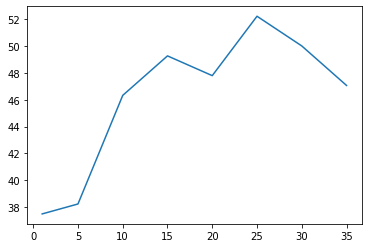

In [74]:
run_knn_opt(X_train, X_val, X_test, y_train, y_val, y_test, [1,5,10,15,20,25,30,35])

##### Building model with the optimal value for K

In [75]:
k_opt = 25

classifier = KNeighborsClassifier(n_neighbors = k_opt)
classifier.fit(X_train,y_train)

# Predicting the test set result
y_pred = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)
y_pred_val = classifier.predict(X_val)


# Evaluating the model
accuracy_test = round(100 * accuracy_score(y_test, y_pred), 2)
cm_test = pd.DataFrame(confusion_matrix(y_test,y_pred))
PRF_test = precision_recall_fscore_support(y_test, y_pred, average='weighted')

accuracy_train = round(100 * accuracy_score(y_train, y_pred_train), 2)
cm_train = pd.DataFrame(confusion_matrix(y_train,y_pred_train))
PRF_train = precision_recall_fscore_support(y_train, y_pred_train, average='weighted')

accuracy_val = round(100 * accuracy_score(y_val, y_pred_val), 2)
cm_val = pd.DataFrame(confusion_matrix(y_val,y_pred_val))
PRF_val = precision_recall_fscore_support(y_val, y_pred_val, average='weighted')

print("***** Test Set Evaluation *****")
print("Confusion Matrix")
display(cm_test)
print("Accuracy: ", accuracy_test)
print("Precision: ", round(PRF_test[0], 2))
print("Recall: ", round(PRF_test[1], 2))
print("F1_score: ", round(PRF_test[2], 2))

print()

print("***** Training Set Evaluation *****")
print("Confusion Matrix")
display(cm_train)
print("Accuracy: ", accuracy_train)
print("Precision: ", round(PRF_train[0], 2))
print("Recall: ", round(PRF_train[1], 2))
print("F1_score: ", round(PRF_train[2], 2))
print()

print("***** Validation Set Evaluation *****")
print("Confusion Matrix")
display(cm_val)
print("Accuracy: ", accuracy_val)
print("Precision: ", round(PRF_val[0], 2))
print("Recall: ", round(PRF_val[1], 2))
print("F1_score: ", round(PRF_val[2], 2))

***** Test Set Evaluation *****
Confusion Matrix


,0,1,2
0,58,1,6
1,22,0,2
2,35,0,13


Accuracy:  51.82
Precision:  0.46
Recall:  0.52
F1_score:  0.44

***** Training Set Evaluation *****
Confusion Matrix


,0,1,2
0,441,7,77
1,154,13,36
2,269,2,109


Accuracy:  50.81
Precision:  0.52
Recall:  0.51
F1_score:  0.45

***** Validation Set Evaluation *****
Confusion Matrix


,0,1,2
0,53,0,11
1,19,2,5
2,30,0,16


Accuracy:  52.21
Precision:  0.6
Recall:  0.52
F1_score:  0.47


#### Applying KNN on the Word2Vec Sentence Embeddings [LEMMATIZATION]

In [76]:
knn_train_lem = train_data[['claim', 'lemmatized_words', 'claim_label']]
knn_test_lem = test_data[['claim', 'lemmatized_words', 'claim_label']]

In [77]:
# getting the sentence embedding of the training data
knn_train_lem = get_sentence_embedding(knn_train_lem, 'lemmatized_words', train_embedding_lem, test_embedding_lem)
knn_train_lem.shape

(1108, 102)

In [78]:
knn_train_lem.head()

,claim,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,claim_label
0,"When the PDO last switched to a cool phase, gl...",-0.345936,0.706018,0.100456,-0.675281,0.246900,-0.569135,0.320590,-0.052354,-0.615797,...,0.395023,-0.030645,-0.202182,0.046103,0.033127,0.195889,0.599021,0.025578,0.548999,2
1,as time progresses and fossil fuel emissions i...,0.012443,0.566822,-0.052595,-0.472698,0.261651,-0.704134,0.511351,-0.396484,-0.810016,...,0.338197,-0.132150,-0.191543,0.114661,0.109580,0.124617,0.417906,0.169635,0.427361,2
2,Hurricanes aren't linked to global warming,-0.431466,0.379811,0.235503,-0.310120,0.117246,-0.386072,0.235425,0.039873,-0.752727,...,0.342476,-0.192771,-0.080921,-0.088410,0.050677,0.323307,0.373415,-0.116031,0.892965,2
3,Ljungqvist's millennial temperature reconstruc...,-0.055630,0.278781,-0.042670,-0.272262,0.142379,-0.297917,0.217664,-0.158459,-0.328237,...,0.158903,-0.013593,-0.088179,0.039795,0.028663,0.054462,0.223234,0.058513,0.155024,2
4,"More importantly, the OISM list only contains ...",-0.045903,0.342336,-0.076491,-0.339781,0.214292,-0.439880,0.358467,-0.284806,-0.501415,...,0.225941,-0.045113,-0.116830,0.031503,0.077083,0.094563,0.261866,0.096303,0.236142,2


In [79]:
knn_test_lem = get_sentence_embedding(knn_test_lem, 'lemmatized_words', train_embedding_lem, test_embedding_lem)
knn_test_lem.shape

(273, 102)

In [80]:
knn_test_lem.head()

,claim,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,claim_label
0,"Trenberth's views are clarified in the paper ""...",-0.169279,0.411608,-0.007784,-0.427708,0.228004,-0.519108,0.416482,-0.251231,-0.650693,...,0.301939,-0.089750,-0.127070,0.006717,0.098947,0.171165,0.343460,0.073811,0.459416,0
1,"When life is considered, ocean acidification i...",-0.051836,0.441860,-0.013324,-0.429023,0.201375,-0.557807,0.337861,-0.234280,-0.621595,...,0.211168,-0.022697,-0.118630,0.084540,0.073612,0.119993,0.363265,0.130669,0.384191,1
2,In recent decades this warming has been accomp...,-0.176538,0.573249,0.080099,-0.415338,0.161536,-0.512413,0.163594,-0.070048,-0.613153,...,0.221658,0.014361,-0.116040,0.124437,-0.058253,0.153677,0.493267,0.047804,0.495362,0
3,while it’s true that studies in some regions s...,-0.050857,0.551747,-0.064347,-0.419578,0.241669,-0.494325,0.242887,-0.213535,-0.494752,...,0.220029,0.057642,-0.161597,0.147229,-0.026554,0.040214,0.403734,0.100298,0.184346,1
4,It is unclear whether global warming is increa...,-0.217699,0.382396,0.083992,-0.333230,0.151969,-0.416176,0.261340,-0.094148,-0.618782,...,0.258520,-0.093164,-0.097014,0.002939,0.048311,0.188588,0.333163,0.000372,0.552540,0


In [81]:
X_train = knn_train_lem.iloc[:,1:-1].values
y_train = knn_train_lem.iloc[:,-1].values
X_test = knn_test_lem.iloc[:,1:-1].values
y_test = knn_test_lem.iloc[:,-1].values

In [82]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

##### Getting the optimal value for K

***** Training Set Evaluation *****

confusion Matrix


,0,1,2
0,439,22,64
1,109,71,23
2,182,30,168


Accuracy:  61.19
F1_score:  0.59


***** Test Set Evaluation *****

confusion Matrix


,0,1,2
0,40,8,17
1,17,2,5
2,33,3,12


Accuracy:  39.42
F1_score:  0.37


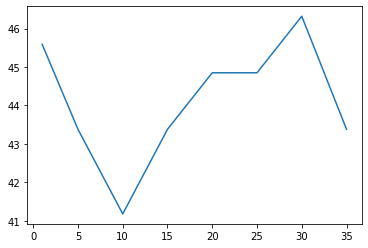

In [83]:
run_knn_opt(X_train, X_val, X_test, y_train, y_val, y_test, [1,5,10,15,20,25,30,35])

##### Building model with the optimal value for K

In [84]:
k_opt = 30

classifier = KNeighborsClassifier(n_neighbors = k_opt)
classifier.fit(X_train,y_train)

# Predicting the test set result
y_pred = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)
y_pred_val = classifier.predict(X_val)


# Evaluating the model
accuracy_test = round(100 * accuracy_score(y_test, y_pred), 2)
cm_test = pd.DataFrame(confusion_matrix(y_test,y_pred))
PRF_test = precision_recall_fscore_support(y_test, y_pred, average='weighted')

accuracy_train = round(100 * accuracy_score(y_train, y_pred_train), 2)
cm_train = pd.DataFrame(confusion_matrix(y_train,y_pred_train))
PRF_train = precision_recall_fscore_support(y_train, y_pred_train, average='weighted')

accuracy_val = round(100 * accuracy_score(y_val, y_pred_val), 2)
cm_val = pd.DataFrame(confusion_matrix(y_val,y_pred_val))
PRF_val = precision_recall_fscore_support(y_val, y_pred_val, average='weighted')

print("***** Test Set Evaluation *****")
print("Confusion Matrix")
display(cm_test)
print("Accuracy: ", accuracy_test)
print("Precision: ", round(PRF_test[0], 2))
print("Recall: ", round(PRF_test[1], 2))
print("F1_score: ", round(PRF_test[2], 2))

print()

print("***** Training Set Evaluation *****")
print("Confusion Matrix")
display(cm_train)
print("Accuracy: ", accuracy_train)
print("Precision: ", round(PRF_train[0], 2))
print("Recall: ", round(PRF_train[1], 2))
print("F1_score: ", round(PRF_train[2], 2))
print()

print("***** Validation Set Evaluation *****")
print("Confusion Matrix")
display(cm_val)
print("Accuracy: ", accuracy_val)
print("Precision: ", round(PRF_val[0], 2))
print("Recall: ", round(PRF_val[1], 2))
print("F1_score: ", round(PRF_val[2], 2))

***** Test Set Evaluation *****
Confusion Matrix


,0,1,2
0,52,1,12
1,15,0,9
2,40,0,8


Accuracy:  43.8
Precision:  0.33
Recall:  0.44
F1_score:  0.36

***** Training Set Evaluation *****
Confusion Matrix


,0,1,2
0,448,2,75
1,149,7,47
2,259,1,120


Accuracy:  51.9
Precision:  0.55
Recall:  0.52
F1_score:  0.45

***** Validation Set Evaluation *****
Confusion Matrix


,0,1,2
0,51,1,12
1,16,1,9
2,35,0,11


Accuracy:  46.32
Precision:  0.45
Recall:  0.46
F1_score:  0.4


### <span style="color:blue"> Notes about KNN Classification of Claims </span>

We applied KNN classification algorithm on the claims in the dataset to see how effective the word2vec embeddings will be at predicting claim labels.

The word2vec model has embeddings for words but the claims are sentences so an averaging technique was used in embedding the claims using the word2vec embeddings. 

$\textrm{claim embedding} = \frac{1}{m} \sum \limits _{j=1} ^{m} X_{j}$

*where:* <br>
*m = number of words in the claim* <br>
*$X_{j}$ = word embedding* <br>
<br><br><br>


- The optimal value of K for stemmed model was 25 while that of the lemmatized model was 30. 
<br><br><br>


- Stemmed Corpus
|  | Accuracy | Precision | Recall | F1 Score |
| --- | --- | --- |--- |-- |
|   Training Set  | 50.81 | 0.52 | 0.51 | 0.45|
|   Validation| 52.21 | 0.6 | 0.52 | 0.47|
|   Test Set | 51.82 | 0.46 | 0.52 | 0.44|

- Lemmatized Corpus
|  | Accuracy | Precision | Recall | F1 Score |
| --- | --- | --- |--- |-- |
|   Training Set  | 51.9 | 0.55 | 0.52 | 0.45|
|   Validation| 46.32 | 0.45 | 0.46 | 0.4|
|   Test Set | 43.8 | 0.33 | 0.44 | 0.36|


- From the tables above, both models did not perform very well but the stemmed model still performed better than the lemmatized model.


## <span style="color:blue">Q.3 Arithmetic Relationships </span>

In [85]:
model_stem.wv.most_similar(positive=['ice', 'warm'], negative=['cold'], topn=5)

[('rise', 0.8680513501167297),
 ('level', 0.8461002707481384),
 ('amplif', 0.8245322704315186),
 ('overnight', 0.8015544414520264),
 ('sea', 0.7908920049667358)]

#### **Relationship 1 [STEMMED]**

ICE + WARM - COLD

- Expected Answer - WATER/SEA/OCEAN
- SEA is included in the similar answers, so the performance here is reasonable

In [86]:
model_lem.wv.most_similar(positive=['ice', 'warm'], negative=['cold'], topn=5)

[('rise', 0.9179260730743408),
 ('level', 0.8902413249015808),
 ('acceler', 0.8463035225868225),
 ('millimet', 0.8399427533149719),
 ('centimet', 0.8393895030021667)]

#### **Relationship 1 [LEMMATIZED]**

ICE + WARM - COLD

- Expected Answer - WATER/SEA/OCEAN
- The performance here is not good, the similar words are not close to our expectation

In [87]:
model_stem.wv.most_similar(positive=['dark', 'sun'],  topn=5)

[('correl', 0.9977636933326721),
 ('flux', 0.997613251209259),
 ('w', 0.9975903034210205),
 ('even', 0.9975150227546692),
 ('venu', 0.9974710941314697)]

#### **Relationship 2 [STEMMED]**

DARK + SUN

- Expected Answer - DAY/LIGHT
- The performance here is not good, the similar words are not close to our expectation

In [88]:
model_lem.wv.most_similar(positive=['dark', 'sun'],  topn=5)

[('usual', 0.9989912509918213),
 ('ground', 0.9987369775772095),
 ('close', 0.9982661604881287),
 ('drier', 0.9982385635375977),
 ('photospher', 0.9982142448425293)]

#### **Relationship 2 [LEMMATIZED]**

DARK + SUN

- Expected Answer - DAY/LIGHT
- The performance here is not good, the similar words are not close to our expectation

In [89]:
model_stem.wv.most_similar(positive=['rise', 'gradual'], negative=['increas'],  topn=5)

[('ft', 0.955589771270752),
 ('antarct', 0.9517379403114319),
 ('sea', 0.9496850967407227),
 ('arctic', 0.9494023323059082),
 ('shrinkag', 0.9458703398704529)]

#### **Relationship 3 [STEMMED]**

RISING + GRADUAL - INCREASING 

- Expected Answer - SLOW/REDUCE
- Shrinkage represents reduction, this is the most similar option which is good
- ft is listed among the similar words, so it shows some relationship between this adjective that describe measurement and a unit of measurement 

In [90]:
#rising + gradual - increasing
model_lem.wv.most_similar(positive=['rise', 'gradual'], negative=['increase'],  topn=5)

[('centimet', 0.9749728441238403),
 ('level', 0.969101071357727),
 ('sea', 0.9589604735374451),
 ('cm', 0.9261975884437561),
 ('metr', 0.9199014902114868)]

#### **Relationship 3 [LEMMATIZED]**

RISING + GRADUAL - INCREASING 

- Expected Answer - SLOW/REDUCE
- centrimet, ft and metr are listed among the similar words, so it shows some relationship between these adjectives that describe measurement and a unit of measurement 
- Not up to expectation

In [92]:
model_stem.wv.most_similar(positive=['summer', 'cold'], negative=['sun'],  topn=5)

[('record', 0.9524875283241272),
 ('epica', 0.9338551759719849),
 ('hemispher', 0.9328180551528931),
 ('pliocen', 0.9245319366455078),
 ('phalodi', 0.9192031621932983)]

#### **Relationship 4 [STEMMED]**

SUMMER + COLD - SUN

- Expected Answer - WINTER
- None of the answers are similar to our expectation

In [93]:
model_lem.wv.most_similar(positive=['summer', 'cold'], negative=['sun'], topn=5)

[('epica', 0.9836907982826233),
 ('record', 0.9543653726577759),
 ('asian', 0.9496455192565918),
 ('age', 0.9428194165229797),
 ('unfrozen', 0.9415284991264343)]

#### **Relationship 4 [LEMMATIZED]**

SUMMER + COLD - SUN

- Expected Answer - WINTER
- None of the answers are similar to our expectation

In [94]:
model_stem.wv.most_similar(positive=['extrem'], negative=['littl'],  topn=5)

[('domino', 0.5273354649543762),
 ('misunderstood', 0.3741205632686615),
 ('cca', 0.367966890335083),
 ('tracker', 0.3577365577220917),
 ('climat', 0.34025222063064575)]

#### **Relationship 5 [STEMMED]**

EXTREME - LITTLE

- Expected Answer - AVERAGE
- None of the answers are similar to our expectation

In [95]:
model_lem.wv.most_similar(positive=['extreme'], negative=['little'],  topn=5)

[('nca', 0.7232496738433838),
 ('referenc', 0.67863929271698),
 ('deadlin', 0.6473028063774109),
 ('facts', 0.5495574474334717),
 ('dimens', 0.5451451539993286)]

#### **Relationship 5 [LEMMATIZED]**

EXTREME - LITTLE

- Expected Answer - AVERAGE
- None of the answers are similar to our expectation

**Our model did not do well on arithmetic relationships, perhaps because of the size of the dataset**

## <span style="color:blue"> Q.4 Arithmetic Relationships on Pretrained Models </span>

In [96]:
W2V_pretrained.wv.most_similar(positive=['ice', 'warm'], negative=['cold'],  topn=5)

[('beds', 0.6540449261665344),
 ('snow', 0.6527976989746094),
 ('rocks', 0.6431947946548462),
 ('frozen', 0.6252524852752686),
 ('rain', 0.620692253112793)]

#### **Relationship 1 [Word2Vec pretrained]**

ICE + WARM - COLD

- Expected Answer - WATER/SEA/OCEAN
- RAIN is included in the similar answers, so the performance here is reasonable, but not much better than our model

In [97]:
GloVe_pretrained.most_similar(positive=['ice', 'warm'], negative=['cold'],  topn=5)

[('plate', 0.7150594592094421),
 ('silver', 0.6485081911087036),
 ('sparkling', 0.6361935138702393),
 ('skate', 0.6235347986221313),
 ('cream', 0.6151866316795349)]

#### **Relationship 1 [GloVe pretrained]**

ICE + WARM - COLD

- Expected Answer - WATER/SEA/OCEAN
- No reasonable similar word
- Bad performance

In [98]:
W2V_pretrained.wv.most_similar(positive=['dark', 'sun'],  topn=5)

[('sky', 0.7675054669380188),
 ('bright', 0.7449434995651245),
 ('moon', 0.7209031581878662),
 ('shining', 0.7030410170555115),
 ('venus', 0.668627142906189)]

#### **Relationship 2 [Word2Vec pretrained]**

DARK + SUN

- Expected Answer - DAY/LIGHT
- Bright is very similar to our expectation, sky and shining are also related.
- Acceptable performance

In [99]:
GloVe_pretrained.most_similar(positive=['dark', 'sun'],  topn=5)

[('bright', 0.8286197185516357),
 ('sky', 0.7863613963127136),
 ('blue', 0.7860472798347473),
 ('eyes', 0.780402421951294),
 ('light', 0.7717483043670654)]

#### **Relationship 2 [GloVe pretrained]**

DARK + SUN

- Expected Answer - DAY/LIGHT
- Bright is very similar to our expectation, Light hits the nail on the head, sky is also related.
- Good performance

In [100]:
W2V_pretrained.wv.most_similar(positive=['rise', 'gradual'], negative=['increase'],  topn=5)

[('modernism', 0.5756148099899292),
 ('chaos', 0.5343645811080933),
 ('emergence', 0.5341908931732178),
 ('enlightenment', 0.5231706500053406),
 ('imperialism', 0.5140310525894165)]

#### **Relationship 3 [Word2Vec pretrained]**

RISE + GRADUAL - INCREASE

- Expected Answer - SLOW
- Emergence is related
- Below average performance

In [101]:
GloVe_pretrained.most_similar(positive=['rise', 'gradual'], negative=['increase'],  topn=5)

[('inexorable', 0.7363815903663635),
 ('upturn', 0.7345753908157349),
 ('precipitous', 0.7254896759986877),
 ('stagnation', 0.7136895656585693),
 ('downward', 0.6995311379432678)]

#### **Relationship 3 [GloVe pretrained]**

RISE + GRADUAL - INCREASE

- Expected Answer - SLOW
- Stagnation and downward are related
- Below average performance

In [102]:
W2V_pretrained.wv.most_similar(positive=['summer', 'cold'], negative=['sun'], topn=5)

[('winter', 0.7164311408996582),
 ('autumn', 0.5591098070144653),
 ('spring', 0.5445659160614014),
 ('winters', 0.5399829149246216),
 ('drought', 0.5285353660583496)]

#### **Relationship 4 [Word2Vec pretrained]**

SUMMER + COLD - SOLAR 

- Expected Answer - WINTER
- Winter is the most similar word according to this model, winters is also listed
- Great performance on this relationship

In [103]:
GloVe_pretrained.most_similar(positive=['summer', 'cold'], negative=['sun'], topn=5)

[('winter', 0.772019624710083),
 ('spring', 0.6544264554977417),
 ('midst', 0.6353206634521484),
 ('beginning', 0.6343027949333191),
 ('decade', 0.6326386332511902)]

#### **Relationship 4 [GloVe pretrained]**

SUMMER + COLD - SOLAR 

- Expected Answer - WINTER
- Winter is the most similar word according to this model
- Great performance on this relationship

In [104]:
W2V_pretrained.wv.most_similar(positive=['extreme'], negative=['little'],  topn=5)

[('affecting', 0.41925716400146484),
 ('malarial', 0.4119103252887726),
 ('severity', 0.3964223265647888),
 ('unwanted', 0.3828401565551758),
 ('frontal', 0.3798210918903351)]

#### **Relationship 5 [Word2Vec pretrained]**

EXTREME - LITTLE

- Expected Answer - AVERAGE
- None of the similar words are related
- Poor performance

In [105]:
GloVe_pretrained.most_similar(positive=['extreme'], negative=['little'],  topn=5)

[('socionics', 0.6343272924423218),
 ('trachoma', 0.6251498460769653),
 ('gender-based', 0.6238468885421753),
 ('cagefighting', 0.6164419651031494),
 ('epizootic', 0.6104960441589355)]

#### **Relationship 5 [Word2Vec pretrained]**

EXTREME - LITTLE

- Expected Answer - AVERAGE
- None of the similar words are related
- Poor performance